In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import KFold

In [2]:
iris = datasets.load_iris()

In [3]:
X = iris.data
y = iris.target

In [4]:
X, y = shuffle(X, y)

In [5]:
size = 0.3
test_size = int(size * len(X))
X_train, X_test = X[:test_size], X[test_size:]
y_train, y_test = y[:test_size], y[test_size:]


In [6]:
X_test = X_test.T

In [7]:
class MLP_iris:
    
    def __init__(self,sizes,alpha = 0.1, eta = 0.1,epoch = 100):
        
        self.sizes = sizes
        self.epoch = epoch
        self.eta = eta
        self.alpha = alpha / alpha
        self.error= []
        
        self.input_layer = self.sizes[0]
        self.hidden_1 = self.sizes[1]
        self.output_layer = self.sizes[2]
        
        self.W1 = np.random.rand(self.hidden_1, self.input_layer) - 0.5
        self.b1 = np.random.rand(self.hidden_1, 1) - 0.5
        self.W2 = np.random.rand(self.output_layer, self.hidden_1) - 0.5
        self.b2 = np.random.rand(self.output_layer, 1) - 0.5
        
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))
    
    def forward_prop(self, X):
        
        self.A0 = X
        self.Z1 = np.dot(self.W1, self.A0) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        
        return self.A2
    
    def one_hot(self,Y):
        one_hot_Y = np.zeros((Y.size, 3))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    def backward_prop(self, y_train, output, start_id, end_id):
        
        one_hot_y = self.one_hot(y_train)
        one_hot_y = one_hot_y[:,start_id:end_id]
        
        self.dA2 = output - one_hot_y
        self.dZ2 = np.multiply(self.sigmoid(self.Z2,derivative=True), self.dA2)
        self.dW2 = 1/self.dZ2.shape[1] * np.dot(self.dZ2, self.A1.T)
        self.db2 = 1/self.dZ2.shape[1] * np.sum(self.dZ2, axis=1, keepdims=True)
        
        self.dA1 = np.dot(self.W2.T, self.dZ2)
        self.dZ1 = np.multiply(self.sigmoid(self.Z1,derivative=True), self.dA1)
        self.dW1 = 1/self.dZ1.shape[1] * np.dot(self.dZ1, self.A0.T)
        self.db1 = 1/self.dZ1.shape[1] * np.sum(self.dZ1, axis=1, keepdims=True)
        
        
        self.W2 = self.alpha * self.W2 - self.eta * self.dW2
        self.b2 = self.alpha * self.b2 - self.eta * self.db2
        self.W1 = self.alpha * self.W1 - self.eta * self.dW1
        self.b1 = self.alpha * self.b1 - self.eta * self.db1
    
    
    def train(self, X, y, batch_size):
        
        self.batch_size = batch_size
        for iteration in range(self.epoch):
            
            m = 0
            accuracy = 0
            kf = KFold(n_splits=10)
            for train_index, test_index in kf.split(X, y):
                
                x_train, x_test = X[train_index,:], X[test_index,:]
                y_train, y_test = y[train_index],y[test_index]
                
                x_train = x_train.T
                x_test = x_test.T
                self.batch_size = min(self.batch_size, x_train.shape[1])
                start_id, end_id = 0, self.batch_size
                while end_id <= x_train.shape[1]:

                    x = x_train[:,start_id: end_id]
                    output = self.forward_prop(x)
                    m += 1 / self.batch_size * np.sum(np.argmax(output, 0) != y_train[start_id: end_id])
                    self.backward_prop(y_train, output,start_id, end_id)

                    start_id = end_id
                    end_id = end_id + self.batch_size
                
                accuracy += self.get_accuracy(x_test, y_test)
            
            
            print('Cross-Val Accuracy at {}th iteration: {}'.format(iteration + 1, accuracy * 10))
            self.error.append(m)
    
    def predict(self,X):
        
        predictions = []
        
        output = self.forward_prop(X)
        return np.argmax(output, 0)
    
    def confusion_matrix(self, y, y_pred):
        
        classes = np.unique(y)
        conf_mat = np.zeros((len(classes), len(classes)))
        for a, p in zip(y, y_pred):
            conf_mat[a][p] += 1
        print(conf_mat)
    
    def error_iteration_curve(self):
        
        import seaborn as sns
        sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
        fig = plt.figure(figsize=(20,9))
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.plot(self.error,'r--')
        plt.show()
        
    
    def get_accuracy(self, X, y):
        output = np.argmax(self.forward_prop(X), 0)
        return np.sum(output == y) / y.size
    
        
    

## Stochastic Learning

In [9]:
#stochastic
model1 = MLP_iris([4, 4, 3])
model1.train(X_train, y_train, 1)

Cross-Val Accuracy at 1th iteration: 65.5
Cross-Val Accuracy at 2th iteration: 67.5
Cross-Val Accuracy at 3th iteration: 67.5
Cross-Val Accuracy at 4th iteration: 70.0
Cross-Val Accuracy at 5th iteration: 72.5
Cross-Val Accuracy at 6th iteration: 83.50000000000001
Cross-Val Accuracy at 7th iteration: 93.5
Cross-Val Accuracy at 8th iteration: 95.0
Cross-Val Accuracy at 9th iteration: 92.5
Cross-Val Accuracy at 10th iteration: 92.5
Cross-Val Accuracy at 11th iteration: 92.5
Cross-Val Accuracy at 12th iteration: 92.5
Cross-Val Accuracy at 13th iteration: 92.5
Cross-Val Accuracy at 14th iteration: 92.5
Cross-Val Accuracy at 15th iteration: 92.5
Cross-Val Accuracy at 16th iteration: 92.5
Cross-Val Accuracy at 17th iteration: 92.5
Cross-Val Accuracy at 18th iteration: 92.5
Cross-Val Accuracy at 19th iteration: 92.5
Cross-Val Accuracy at 20th iteration: 92.5
Cross-Val Accuracy at 21th iteration: 95.0
Cross-Val Accuracy at 22th iteration: 95.0
Cross-Val Accuracy at 23th iteration: 95.0
Cross-V

In [28]:
y_pred_train_1 = model1.predict(X_train.T)
model1.confusion_matrix(y_train, y_pred_train_1)

[[ 9.  0.  0.]
 [ 0. 14.  1.]
 [ 0.  0. 21.]]


In [29]:
y_pred_test_1 = model1.predict(X_test)
model1.confusion_matrix(y_test, y_pred_test_1)

[[41.  0.  0.]
 [ 0. 30.  5.]
 [ 0.  0. 29.]]


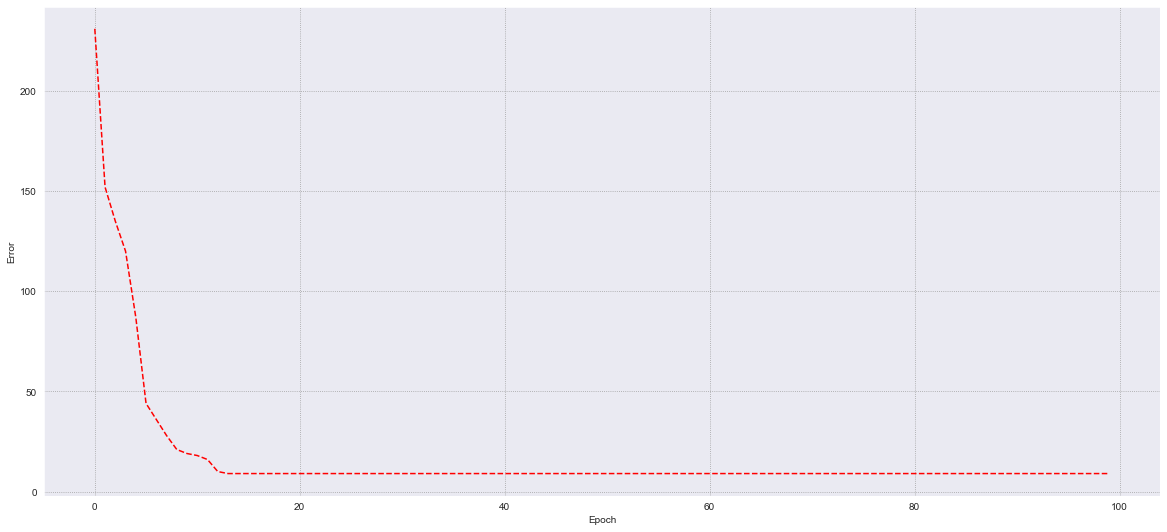

In [30]:
model1.error_iteration_curve()

## Batch Learning

In [31]:
#batch
model2 = MLP_iris([4,3, 3])
model2.train(X_train, y_train, 105)

Cross-Val Accuracy at 1th iteration: 20.0
Cross-Val Accuracy at 2th iteration: 56.0
Cross-Val Accuracy at 3th iteration: 50.0
Cross-Val Accuracy at 4th iteration: 46.0
Cross-Val Accuracy at 5th iteration: 46.0
Cross-Val Accuracy at 6th iteration: 46.0
Cross-Val Accuracy at 7th iteration: 46.0
Cross-Val Accuracy at 8th iteration: 46.0
Cross-Val Accuracy at 9th iteration: 46.0
Cross-Val Accuracy at 10th iteration: 46.0
Cross-Val Accuracy at 11th iteration: 46.0
Cross-Val Accuracy at 12th iteration: 46.0
Cross-Val Accuracy at 13th iteration: 46.0
Cross-Val Accuracy at 14th iteration: 46.0
Cross-Val Accuracy at 15th iteration: 46.0
Cross-Val Accuracy at 16th iteration: 46.0
Cross-Val Accuracy at 17th iteration: 46.0
Cross-Val Accuracy at 18th iteration: 46.0
Cross-Val Accuracy at 19th iteration: 46.0
Cross-Val Accuracy at 20th iteration: 46.0
Cross-Val Accuracy at 21th iteration: 46.0
Cross-Val Accuracy at 22th iteration: 46.0
Cross-Val Accuracy at 23th iteration: 46.0
Cross-Val Accuracy a

In [32]:
y_pred_train_1 = model2.predict(X_train.T)
model2.confusion_matrix(y_train, y_pred_train_1)

[[ 9.  0.  0.]
 [ 0.  0. 15.]
 [ 0.  0. 21.]]


In [33]:
y_pred_test_1 = model2.predict(X_test)
model2.confusion_matrix(y_test, y_pred_test_1)

[[41.  0.  0.]
 [ 0.  0. 35.]
 [ 0.  0. 29.]]


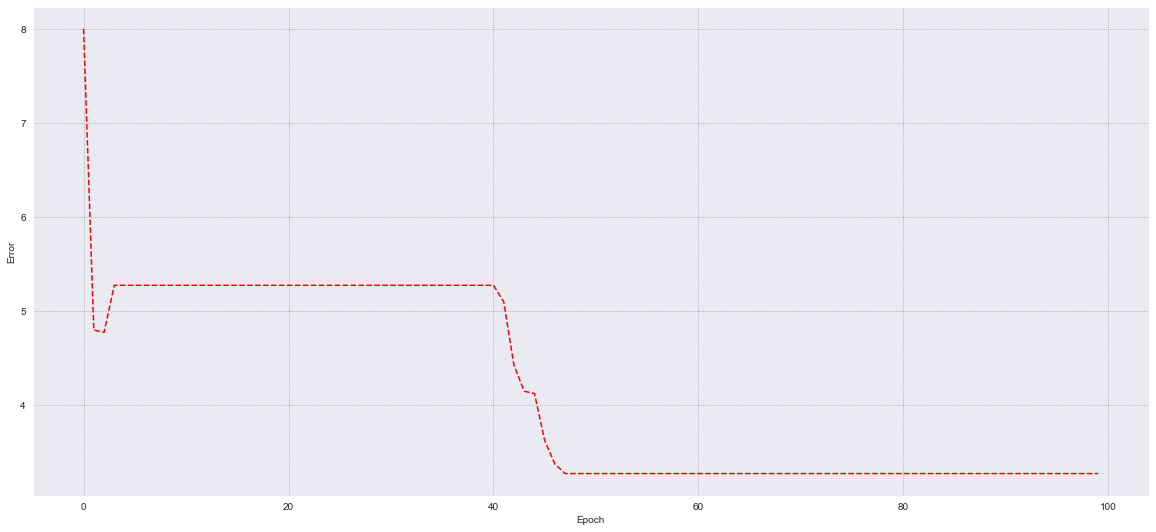

In [34]:
model2.error_iteration_curve()

## Mini-Batch Learning

In [35]:
#minibatch(batch_size = 5)
model3 = MLP_iris([4, 4, 3])
model3.train(X_train, y_train, 5)

Cross-Val Accuracy at 1th iteration: 46.0
Cross-Val Accuracy at 2th iteration: 46.0
Cross-Val Accuracy at 3th iteration: 46.0
Cross-Val Accuracy at 4th iteration: 46.0
Cross-Val Accuracy at 5th iteration: 46.0
Cross-Val Accuracy at 6th iteration: 46.0
Cross-Val Accuracy at 7th iteration: 56.0
Cross-Val Accuracy at 8th iteration: 66.0
Cross-Val Accuracy at 9th iteration: 66.0
Cross-Val Accuracy at 10th iteration: 66.0
Cross-Val Accuracy at 11th iteration: 66.0
Cross-Val Accuracy at 12th iteration: 66.0
Cross-Val Accuracy at 13th iteration: 68.5
Cross-Val Accuracy at 14th iteration: 66.0
Cross-Val Accuracy at 15th iteration: 66.0
Cross-Val Accuracy at 16th iteration: 66.0
Cross-Val Accuracy at 17th iteration: 66.0
Cross-Val Accuracy at 18th iteration: 70.0
Cross-Val Accuracy at 19th iteration: 70.0
Cross-Val Accuracy at 20th iteration: 72.5
Cross-Val Accuracy at 21th iteration: 72.5
Cross-Val Accuracy at 22th iteration: 79.5
Cross-Val Accuracy at 23th iteration: 79.5
Cross-Val Accuracy a

In [36]:
y_pred_train_1 = model3.predict(X_train.T)
model3.confusion_matrix(y_train, y_pred_train_1)

[[ 9.  0.  0.]
 [ 0. 14.  1.]
 [ 0.  0. 21.]]


In [37]:
y_pred_test_1 = model3.predict(X_test)
model3.confusion_matrix(y_test, y_pred_test_1)

[[41.  0.  0.]
 [ 0. 30.  5.]
 [ 0.  0. 29.]]


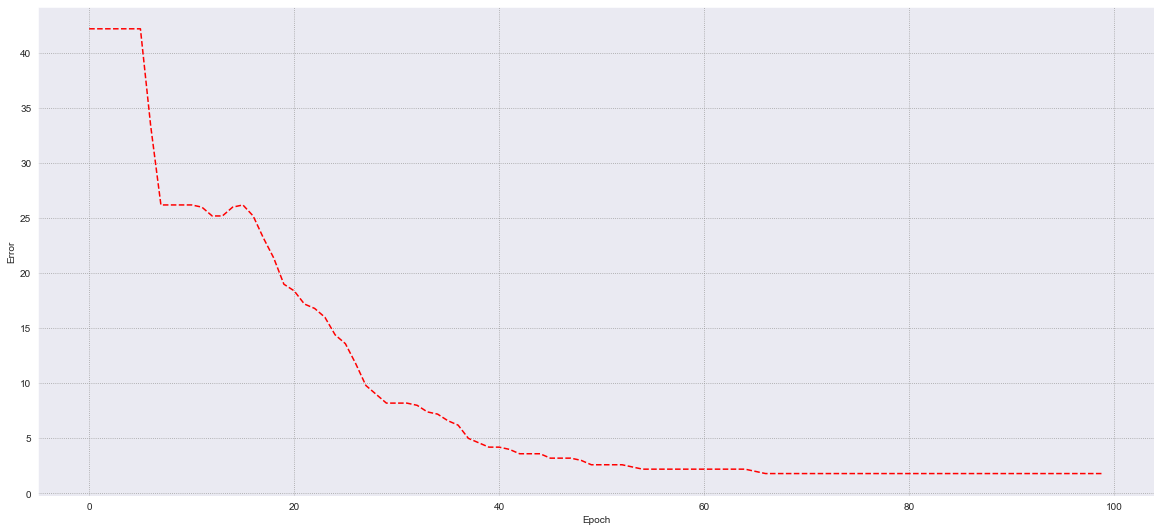

In [38]:
model3.error_iteration_curve()